# 1. Round-off error

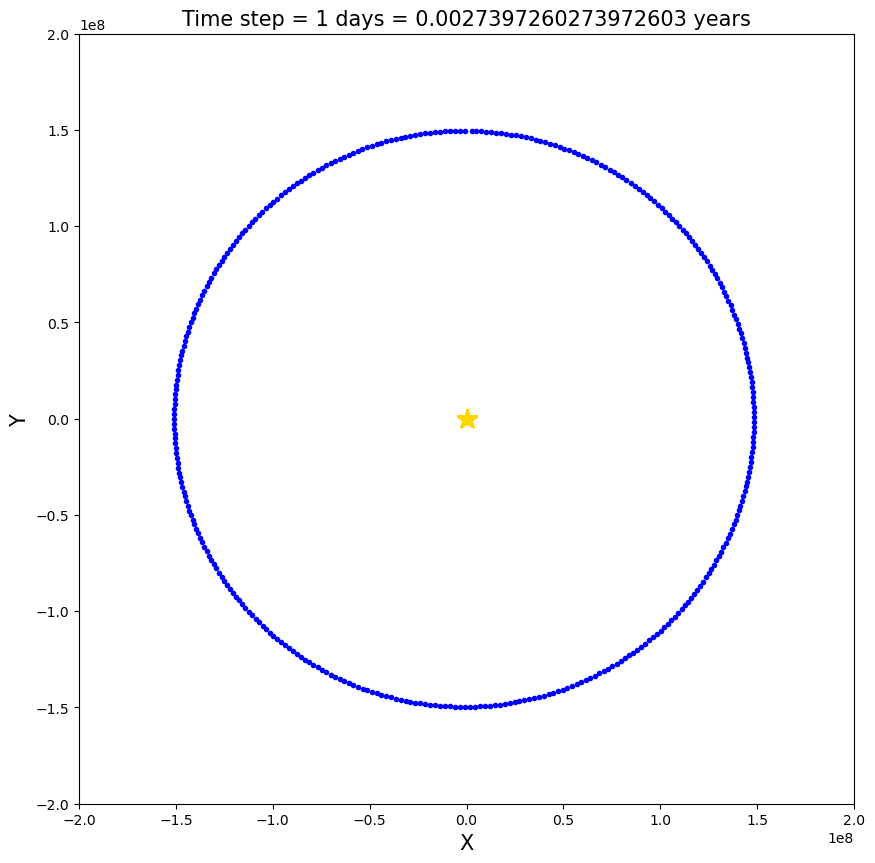

-8.194201812401026e-09

In [6]:
# (a) semi-implicit Euler method for integrating planeraty orbits
import numpy as np
import matplotlib.pyplot as plt


def V_update(V, A, dt):
    V_new = V + A*dt 
    return V_new
    
def X_update(X, V_new, dt):
    X_new = X + V_new*dt
    return X_new


year = 365 #days 


#constants
a_earth_mag = 107000*24**2 #acceleration magnitude [km/day^2]  
E_S_rad = 1.496e8 #[km] 
E_mass = 6e24 #kg
S_mass = 1.9885e30 #kg
G = (6.67430e-20)*(86400**2) #km^3 kg^-1 day^-2
GM = 1.3271e11*86400**2 #km^3 day^-2 standard gravitational parameter

#Initialize positon, velocity, acceleration
#2D Vectors (x,y)
X = np.array([0, E_S_rad]) #starting at (0, R [km]), so acceleration is only in x-dir
V = np.array([np.sqrt(GM/E_S_rad), 0])


dt = 1 #day


def Euler_method(Dt, X, V):
        
    for i, dt in enumerate(Dt):
    
        #Initialize plot
        plt.figure(figsize=(10,10))
        plt.xlim(-2e8, 2e8)
        plt.ylim(-2e8, 2e8)
        
        #print('Time step = ', dt, 'day = ', dt*(1/365), ' years')
        
        # Nsteps * dt = year
        # Nsteps = year/dt
        # always do a one-year integration BUT dt changes
        
        time = np.linspace(1, 365, int(year/dt)) #days
        #print(time)
        
        
        #compute initial energy
        U = -G*E_mass*S_mass/np.linalg.norm(X)
        K = 0.5*E_mass*np.linalg.norm(V)**2
        E_i = K + U

        for t in time: #steps

            X_norm = np.sqrt(X[0]**2 + X[1]**2)
            #unit vector
            n = np.array([X[0]/X_norm, X[1]/X_norm])

            A = -(GM/X_norm**2)*n
            #A = -a_earth_mag*n

            #first update velocity
            V = V_update(V, A, dt)

            #update position
            X = X_update(X, V, dt)
            #print(X)

            plt.plot(X[0], X[1], '.b')
            plt.ylabel('Y', fontsize=15)
            plt.xlabel('X', fontsize=15)
            plt.title('Time step = {0} days = {1} years'.format(dt, dt*(1/365)), fontsize=15)

            #Sun
            plt.plot(0,0, '*', color='gold', markersize=15)
            

        plt.show()
        #compute final energy
        E_f = 0.5*E_mass*np.linalg.norm(V)**2 + -G*E_mass*S_mass/np.linalg.norm(X)
        dE = (E_f - E_i)/E_i
        #print('Initial total energy = ', E_i, 'J')
        #print('Final total energy = ', E_f, 'J')
    return dE
    
#call function
Euler_method([dt], X, V)


<Figure size 1000x1000 with 0 Axes>

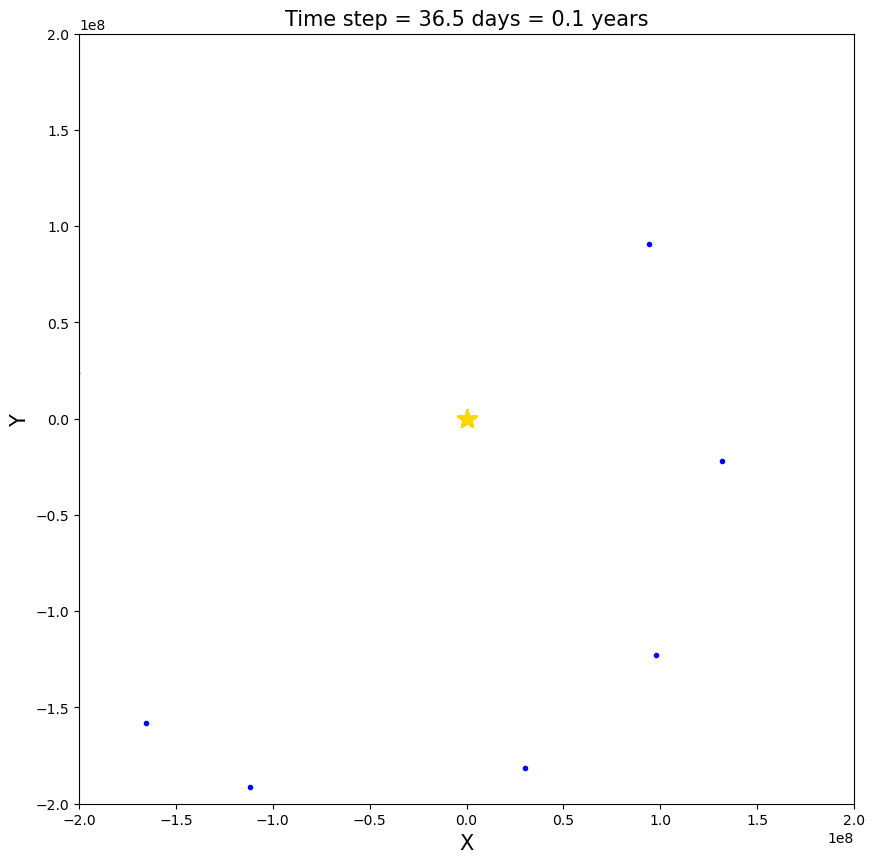

Fractional change in energy =  0.07186356934122097


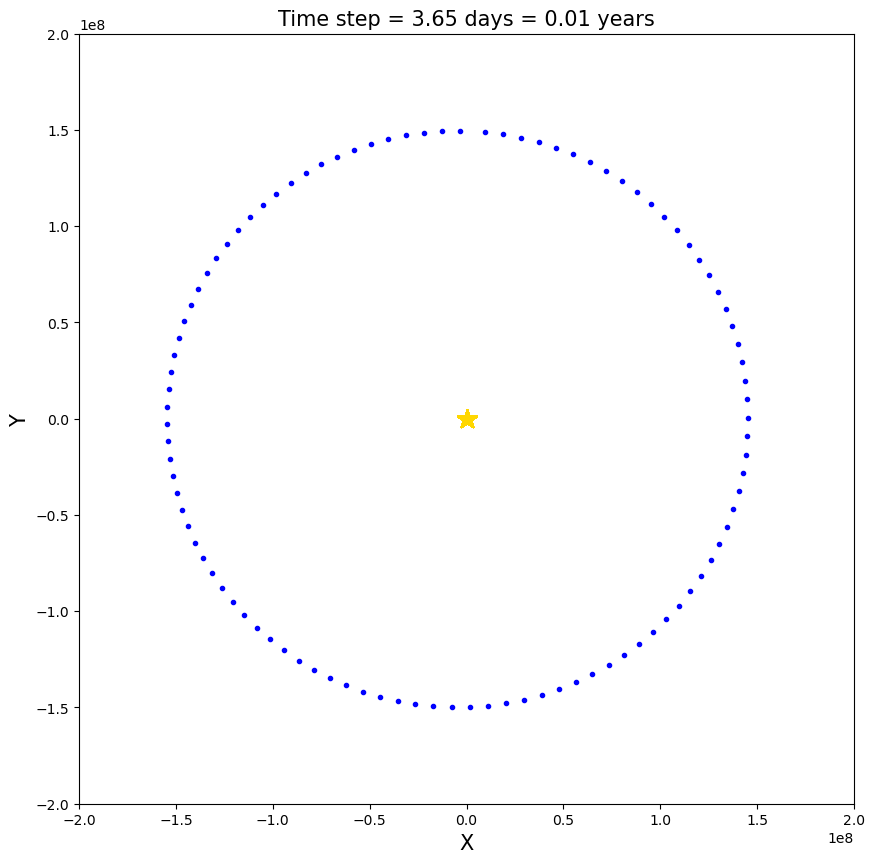

Fractional change in energy =  3.165605880502965e-07


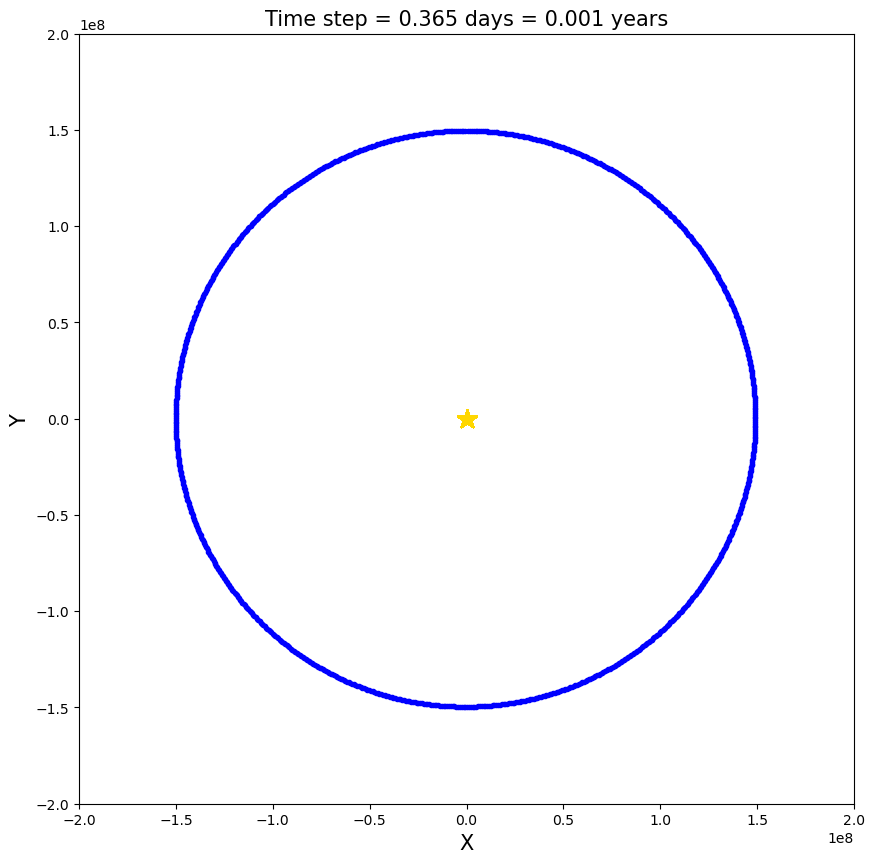

Fractional change in energy =  2.1096112772843078e-09


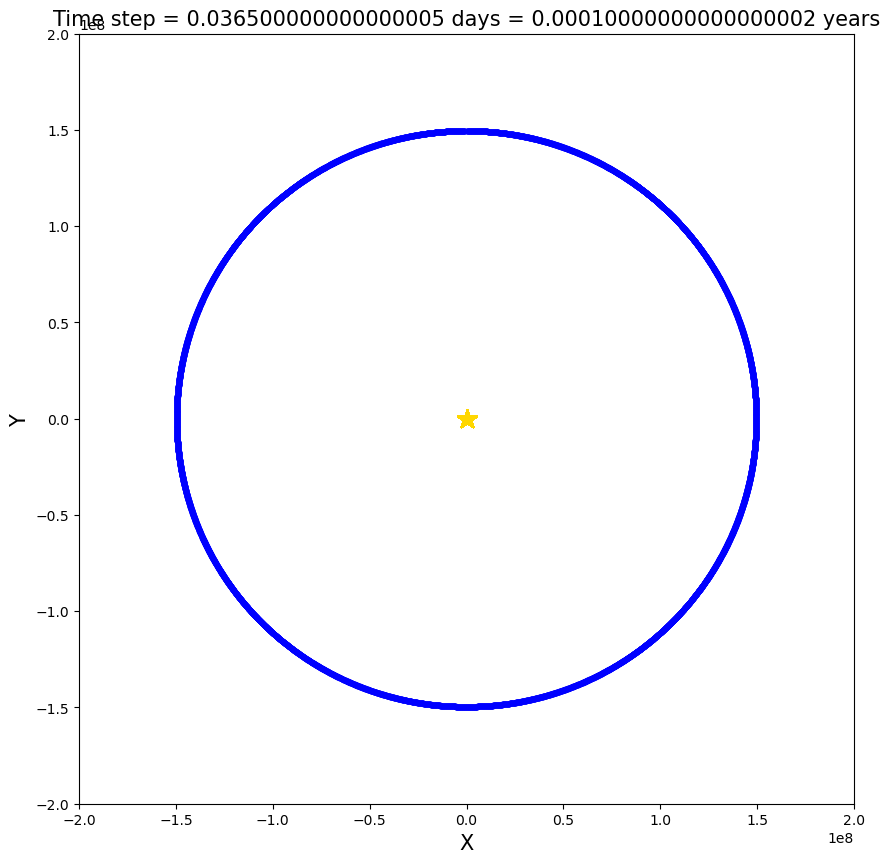

Fractional change in energy =  2.1228658194354268e-10


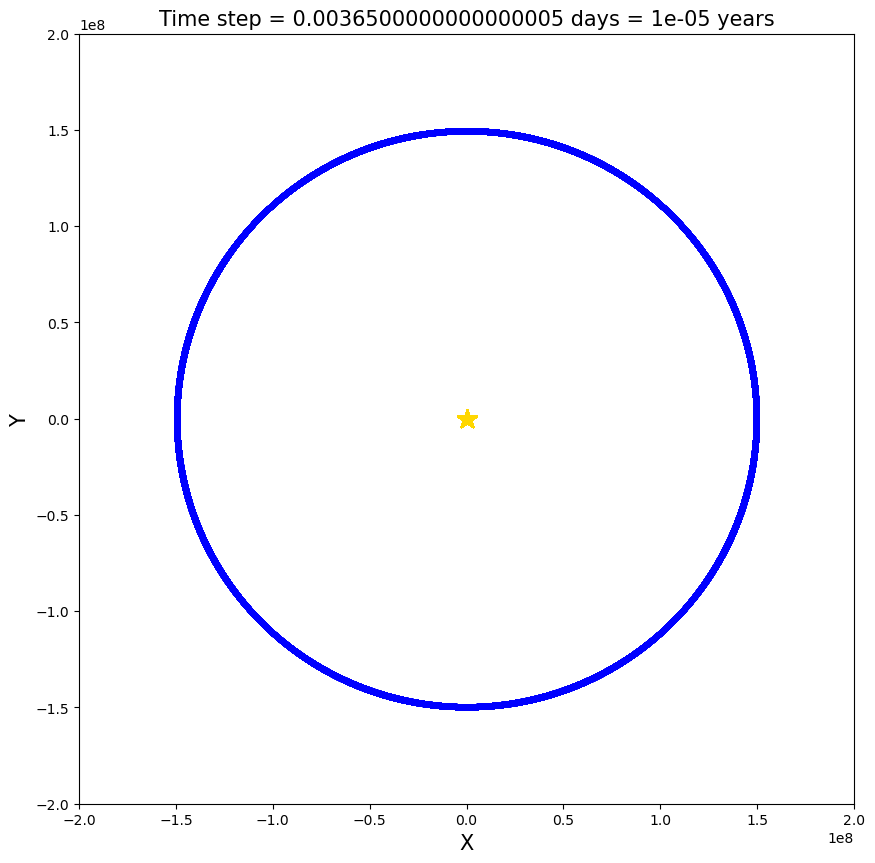

Fractional change in energy =  1.8708589867312258e-11


In [9]:
# (b) Different time steps dt 
# These timesteps are less than a day
# constants need to be in seconds
dt_years = np.array([0.1, 1e-2, 1e-3, 1e-4, 1e-5])#1e-6, 1e-7, 1e-8 
dt_days = dt_years*year
Nsteps = year/dt_days
#print(dt_days)

plt.figure(figsize=(10,10))
E_frac = []
for dt in dt_days:
    dE = Euler_method([dt], X, V)
    print('Fractional change in energy = ', abs(dE))
    E_frac.append(abs(dE))
    #Plot energy difference as a function of Nsteps


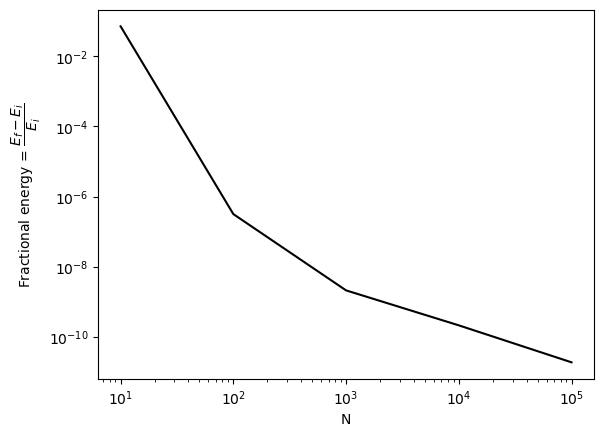

In [12]:
plt.plot(Nsteps, E_frac, 'k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('N')
plt.ylabel('Fractional energy = $\dfrac{E_{f}-E_i}{E_i}$')
plt.show()

Comments:
- The code takes longer than >2hours for any dt smaller than 1e-5. So, in the interest of time, I will avoid running smaller dt's. I understand, however, this might not show the expected behavior for the error as a function of number of points.

- For dt = 0.1 years = 36.5 days, the code does two things:
    - First, the circle is no longer centered at the sun.
    - Second, it does not complete a full turn despite the code calculating the corresponding number of points so that Earth always completes a one-year orbit. 
    
Discussion: 

As expected, error decreases with increasing number of points. However, as discussed during the debug den, at very large Ns, we should see the error starting to go back up. Unfortunately, my code takes too long to run to reach larger N ~$10^{-6}$, and this behaviour is not seen on the plot above.

# 2. Interpolation

In [14]:
import scipy.interpolate
import numpy as np
import matplotlib.pyplot as plt

# (a) calculate pressure and entropy for grid of values

#constants
k_B = 1.3806e-23 #J/K 
h_bar = 1.054e-34 #Js
m_u = 1.6605e-27 #kg atomic mass unit
m = 28*m_u

def pressure(T, rho, k_B, h_bar):
    xlen=np.shape(T)[0]
    ylen=np.shape(T)[1]
    press=np.zeros((xlen,ylen))
    for i in range(xlen):
        for j in range(ylen):
            n = rho[i,j]/m
            press[i,j] = n*k_B*T[i,j] #take log10 later when plotting
    return press

def entropy(T, rho, k_B, h_bar):
    xlen=np.shape(T)[0]
    ylen=np.shape(T)[1]
    entr=np.zeros((xlen,ylen))
    for i in range(xlen):
        for j in range(ylen):
            n = rho[i,j]/m
            nQ = ((m*k_B*T[i, j])/(2*np.pi*h_bar**2))**(3/2)
            entr[i, j] = (5/2 - np.log(n/nQ))  #S/k_B
    return entr


# sample the function on a coarse grid 
# range of temperature and density
tp = np.logspace(2, 3, 15) #kgm^-3
rhop = np.logspace(-6, 0, 15) #K
#np = rhop/m
#tp=np.linspace(100, 1000, 15)
#rhop = 10**np.linspace(-6, 0, 15)


#create grid
Tp, Rhop = np.meshgrid(tp, rhop, indexing='ij')

#pressure
Pp = pressure(Tp, Rhop, k_B, h_bar)
#entropy
Sp = entropy(Tp, Rhop, k_B, h_bar)

# set up interpolation
#pressure
P_interp = scipy.interpolate.RectBivariateSpline(tp, rhop, Pp)
S_interp = scipy.interpolate.RectBivariateSpline(tp, rhop, Sp)

# compute function on a finer grid
tt = np.logspace(2, 3, 100)
rrho = np.logspace(-6, 0, 100)

#nn = rrho/m
#tt = np.linspace(100, 1000, 100)
#rrho = 10**np.linspace(-6, 0, 100)

#fine grid
TTemp, RRho = np.meshgrid(tt, rrho, indexing='ij')


P = pressure(TTemp, RRho, k_B, h_bar)
S = entropy(TTemp, RRho, k_B, h_bar)



# First interpolator: "non-log"

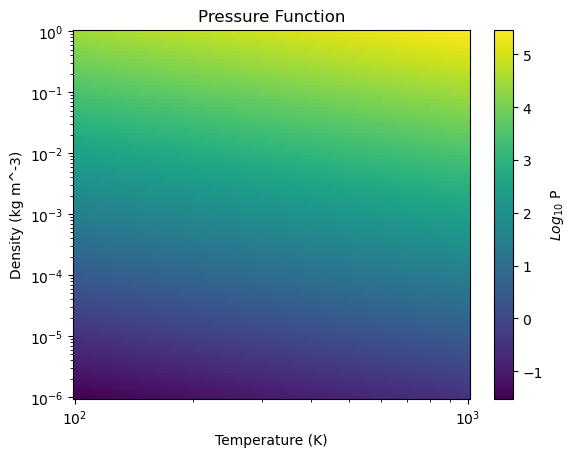

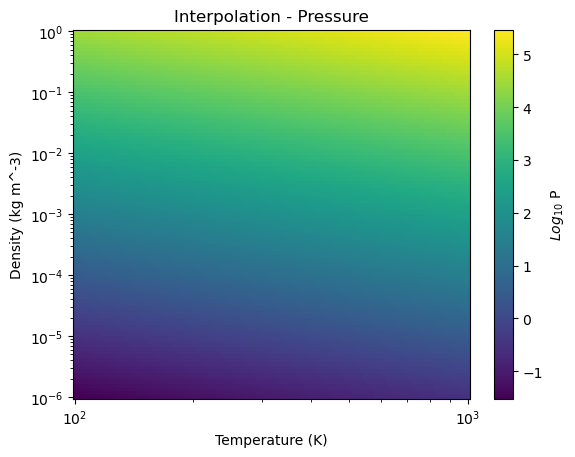

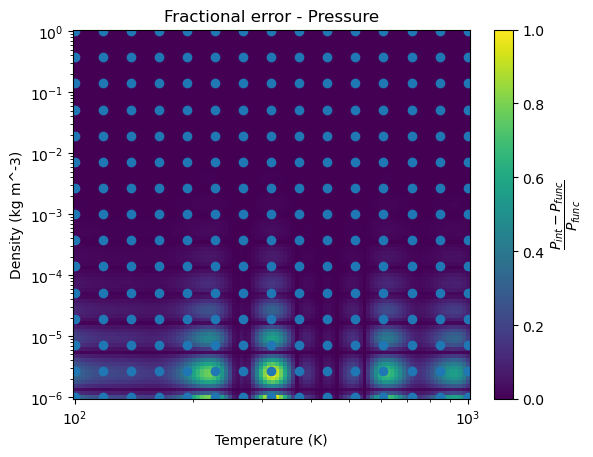

In [15]:
# Plotting interpolation first
#Pressure
plt.pcolormesh(TTemp, RRho, np.log10(P), cmap='viridis')
plt.colorbar(label='$Log_{10}$ P')
plt.xlabel('Temperature (K)')
plt.ylabel('Density (kg m^-3)')
plt.title('Pressure Function')
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.pcolormesh(TTemp, RRho, np.log10(P_interp(TTemp, RRho, grid=False)), cmap='viridis')
plt.colorbar(label='$Log_{10}$ P')
plt.xlabel('Temperature (K)')
plt.ylabel('Density (kg m^-3)')
plt.title('Interpolation - Pressure')
plt.xscale('log')
plt.yscale('log')
plt.show()


#plot the fractional error
plt.pcolormesh(TTemp, RRho, abs((P_interp(TTemp, RRho, grid=False)-P)/P), cmap='viridis')
plt.scatter(Tp, Rhop)
plt.colorbar(label='$\dfrac{P_{int}-P_{func}}{P_{func}}$')
plt.xlabel('Temperature (K)')
plt.ylabel('Density (kg m^-3)')
plt.title('Fractional error - Pressure')
plt.xscale('log')
plt.yscale('log')
plt.show()

Does this make sense? 

We do see some zero error pattern somewhat following the grid shown as blue dots. However, we also see some maximum error areas exactly where the sample grid points are. 

I also used evenly spaced points in log-space, so it does not make sense why the low density zone has larger errors. 

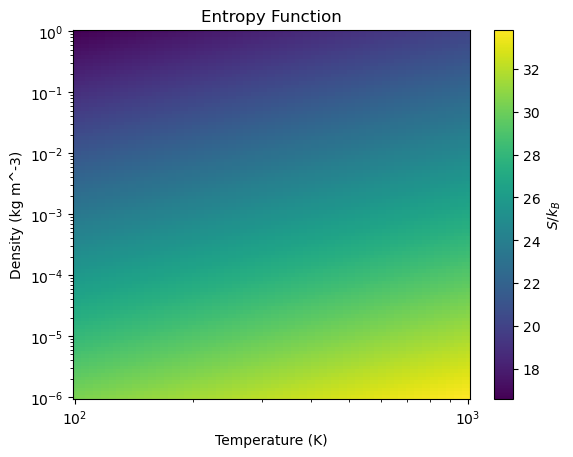

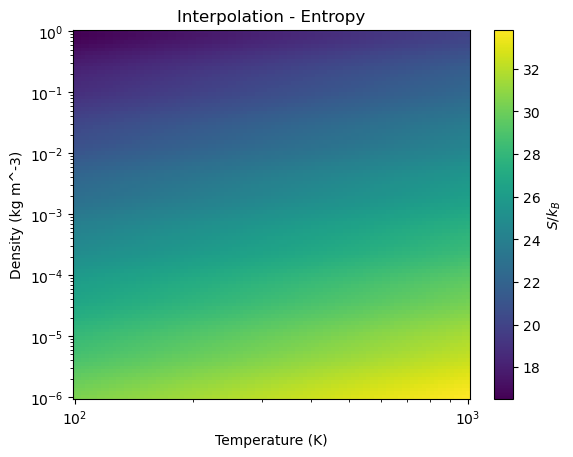

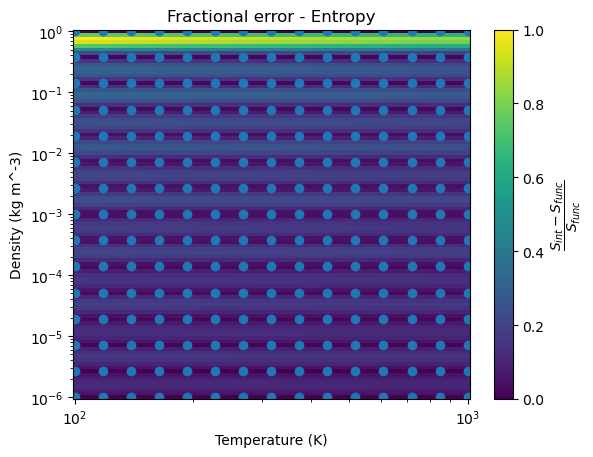

In [16]:
#Entropy
plt.pcolormesh(TTemp, RRho, S, cmap='viridis')
plt.colorbar(label='$S/k_B$')
plt.xscale('log')
plt.yscale('log')
plt.title('Entropy Function')
plt.xlabel('Temperature (K)')
plt.ylabel('Density (kg m^-3)')
plt.show()


plt.pcolormesh(TTemp, RRho, S_interp(TTemp, RRho, grid=False), cmap='viridis')
plt.colorbar(label='$S/k_{B}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Temperature (K)')
plt.ylabel('Density (kg m^-3)')
plt.title('Interpolation - Entropy')
plt.show()


plt.pcolormesh(TTemp, RRho, abs((S-S_interp(TTemp, RRho, grid=False))/S), cmap='viridis')
plt.scatter(Tp, Rhop)
plt.colorbar(label='$\dfrac{S_{int}-S_{func}}{S_{func}}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Temperature (K)')
plt.ylabel('Density (kg m^-3)')
plt.title('Fractional error - Entropy')
plt.show()

Does this make sense? As before, we see some zero-error areas following some of the grid pattern. However, there are other characteristics that might not be as intuitive:

    * There are no vertical lines of zero-error to form a grid.
    * There is a large error area at high densities.  
    * Some areas of maximum error coincide with grid points.
    
    
This entropy interpolation shows similar questionable characteristics, just like the pressure interpolator above. 

Next, I will try to construct the interpolators in a different way to see if the error patterns make more sense.

# Second interpolator: "log"

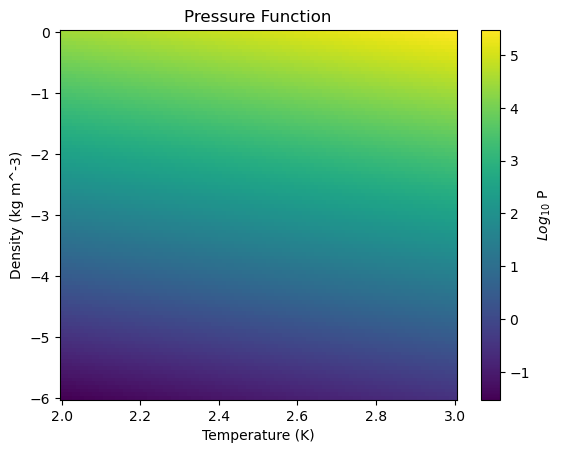

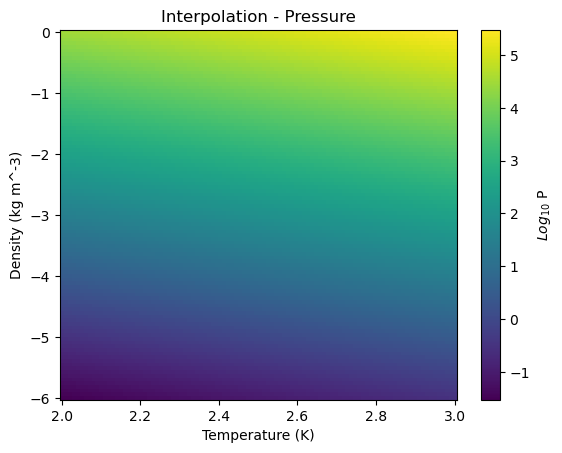

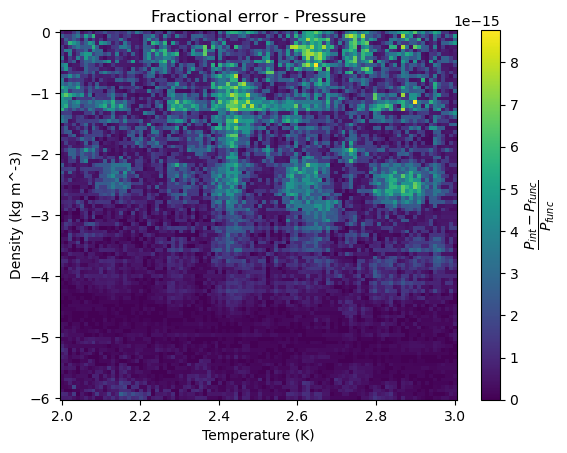

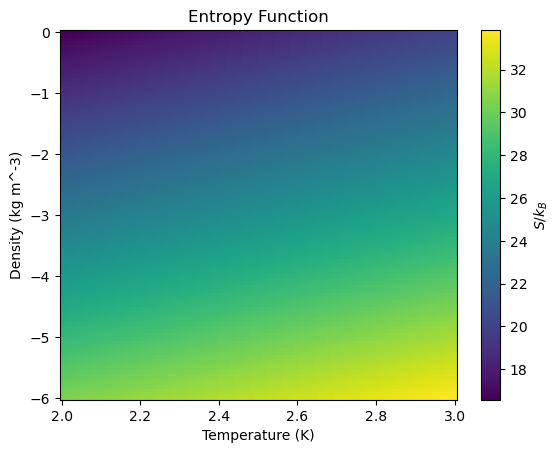

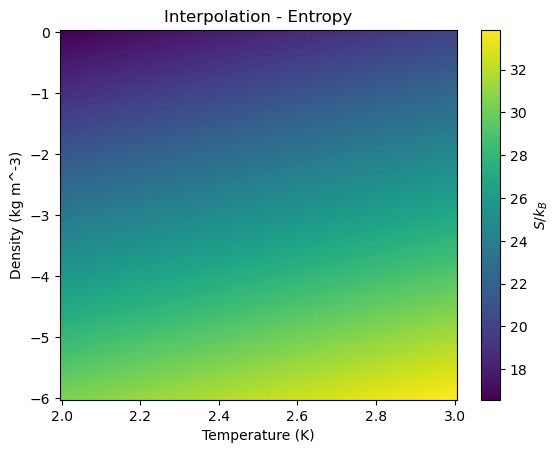

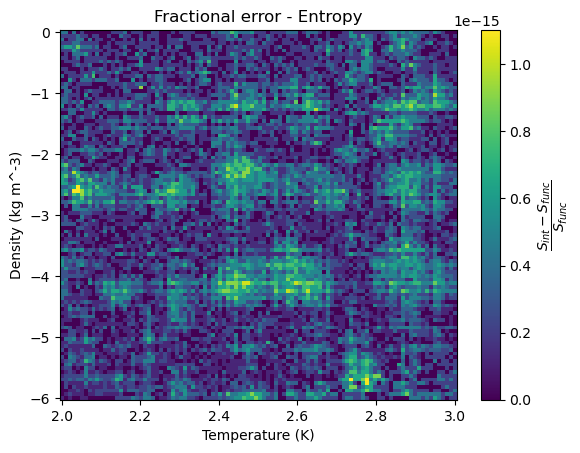

In [17]:
#Let's try one final thing
# make interpolators take logT, log(p) and return logP and S


Pp = pressure(Tp, Rhop, k_B, h_bar)
Sp = entropy(Tp, Rhop, k_B, h_bar)


P = pressure(TTemp, RRho, k_B, h_bar)
S = entropy(TTemp, RRho, k_B, h_bar)


#rewrite interpolators
P_interpLog = scipy.interpolate.RectBivariateSpline(np.log10(tp), np.log10(rhop), np.log10(Pp))
S_interpLog = scipy.interpolate.RectBivariateSpline(np.log10(tp), np.log10(rhop), Sp)



#Pressure
plt.pcolormesh(np.log10(TTemp), np.log10(RRho), np.log10(P), cmap='viridis')
plt.colorbar(label='$Log_{10}$ P')
plt.xlabel('Temperature (K)')
plt.ylabel('Density (kg m^-3)')
plt.title('Pressure Function')
plt.show()


plt.pcolormesh(np.log10(TTemp), np.log10(RRho), P_interpLog(np.log10(TTemp), np.log10(RRho), grid=False), cmap='viridis')
plt.colorbar(label='$Log_{10}$ P')
plt.xlabel('Temperature (K)')
plt.ylabel('Density (kg m^-3)')
plt.title('Interpolation - Pressure')
plt.show()


#plot the fractional error
plt.pcolormesh(np.log10(TTemp), np.log10(RRho), abs((10**P_interpLog(np.log10(TTemp), np.log10(RRho), grid=False)-P)/P), cmap='viridis')
#plt.scatter(Tp, Rhop)
plt.colorbar(label='$\dfrac{P_{int}-P_{func}}{P_{func}}$')
plt.xlabel('Temperature (K)')
plt.ylabel('Density (kg m^-3)')
plt.title('Fractional error - Pressure')
plt.show()


#Entropy
plt.pcolormesh(np.log10(TTemp), np.log10(RRho), S, cmap='viridis')
plt.colorbar(label='$S/k_B$')
plt.xlabel('Temperature (K)')
plt.ylabel('Density (kg m^-3)')
plt.title('Entropy Function')
plt.show()


plt.pcolormesh(np.log10(TTemp), np.log10(RRho), S_interpLog(np.log10(TTemp), np.log10(RRho), grid=False), cmap='viridis')
plt.colorbar(label='$S/k_B$')
plt.xlabel('Temperature (K)')
plt.ylabel('Density (kg m^-3)')
plt.title('Interpolation - Entropy')
plt.show()


#plot the fractional error
plt.pcolormesh(np.log10(TTemp), np.log10(RRho), abs((S_interpLog(np.log10(TTemp), np.log10(RRho), grid=False)-S)/S), cmap='viridis')
plt.colorbar(label='$\dfrac{S_{int}-S_{func}}{S_{func}}$')
plt.xlabel('Temperature (K)')
plt.ylabel('Density (kg m^-3)')
plt.title('Fractional error - Entropy')
plt.show()

Okay. We are getting different fractional errors, and these make more sense!

The fractional error plots don't show as much structure now. In fact, they seem to have reached round-off error since it is $10^{-16}$. This suggests that the interpolator is matching the pressure and entropy functions almost exactly. Instinctively, I want to choose the second interpolator as the correct one, but I will use the method described in 2(b) to confirm that choice. 


For 2(b), I will compute the derivatives for both interpolators to determine which one is correct and thermodynamically consistent. 


# First interpolator: "non-log"



Before computing the numerical derivatives, we need to think about how the interpolator was defined and what the derivative method will return:

$$ 
P(T, \rho)
$$
$$
S(T, \rho)
$$

This means that we need to rewrite the left-hand side such that we have things in terms of $\rho$ and not $n$. Everything else is already in terms of things the interpolator takes/returns. 

By chain rule:

$$
\dfrac{\partial S}{\partial n} = \dfrac{\partial S}{\partial \rho(n)} \dfrac{\partial \rho(n)}{\partial n}
$$

where
$$
 \dfrac{\partial \rho(n)}{\partial n} = 28m_{\mu}
$$
 
So,
$$
\dfrac{\partial S}{\partial n} = 28m_{\mu}\dfrac{\partial S}{\partial \rho}
$$

Finally, we would need to consider the equation:


$$
- \dfrac{\partial S}{\partial n} = \dfrac{1}{n^2} \dfrac{\partial P}{\partial T}
$$


$$
- \dfrac{\partial S}{\partial n} = - 28m_{\mu}\dfrac{\partial S}{\partial \rho} = \dfrac{(28m_{\mu})^2}{\rho^2}\dfrac{\partial P}{\partial T}
$$

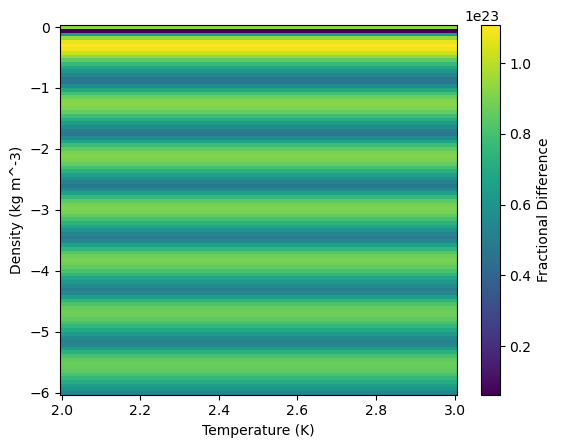

In [19]:
# interp(T, Rho) -> x = T and y = Rho
# ealuated at T and rho values
dPdT_p = P_interp.partial_derivative(dx=1, dy=0)(TTemp, RRho, grid=False)
dSdp_T = S_interp.partial_derivative(dx=0, dy=1)(TTemp, RRho, grid=False)

#print(dPdT_p)
#print(dSdp_T)


# Now, compare the two sides by multiplying by the necessary factor 
LHS = -m*dSdp_T
RHS = ((m**2/RRho**2)*dPdT_p)

frac_diff = (RHS - LHS)/RHS #this should be 0

#print(frac_diff)


#plot fractional difference as a function of T, Rho
plt.pcolormesh(np.log10(TTemp), np.log10(RRho), abs(frac_diff), cmap='viridis')
plt.colorbar(label='Fractional Difference')
plt.xlabel('Temperature (K)')
plt.ylabel('Density (kg m^-3)')
#plt.title('Fractional error - Entropy')
plt.show()

Does this make sense? 

Here we see that the error is in the order of $10^{23}$!, clearly something is very off. 



# Second interpolator: "log" 

The second interpolator is defined such that:

$$
log_{10} P(log_{10}T, log_{10}\rho)
$$

$$
S(log_{10}T, log_{10}\rho)
$$

This means we have to "fix" both sides of the given equation. 


As before, we have:

$$
\dfrac{\partial S}{\partial \rho} = \dfrac{dS}{dn}\dfrac{dn}{d\rho} = \dfrac{dS}{dn} \dfrac{1}{28m_{\mu}}
$$


and

$$
\dfrac{\partial S}{\partial \rho} = \dfrac{dS}{d log_{10}\rho}\dfrac{d log_{10}\rho}{d\rho} = \dfrac{dS}{d log_{10}\rho} \dfrac{1}{\rho ln(10)}
$$

Putting the two together, we can rewrite: 

$$
\dfrac{\partial S}{\partial n} = 28m_{\mu} \dfrac{\partial S}{\partial log_{10}\rho} \dfrac{1}{ln(10)\rho}
$$





We want to do something similar for pressure. First, by chain rule:

$$
\dfrac{\partial log_{10}P}{\partial log_{10}T} = \dfrac{1}{ln(10) P}\dfrac{\partial P}{\partial log_{10}T}
$$

Then, 

$$
\dfrac{\partial P}{\partial T} = \dfrac{\partial P}{\partial log_{10}T}\dfrac{\partial log_{10}T}{\partial T} 
$$

so, 

$$
\dfrac{\partial P}{\partial log_{10}T} = T ln(10) \dfrac{\partial P}{\partial T} 
$$


Finally, putting everything together:
$$
\dfrac{\partial P}{\partial T} = \dfrac{P}{T} \dfrac{\partial log_{10}P}{\partial log_{10}T}
$$


Let's look at the given equation again:
$$
-\dfrac{\partial S}{\partial n} = \dfrac{1}{n^2} \dfrac{\partial P}{\partial T}
$$

$$
-\dfrac{\partial S}{\partial log_{10}\rho} \dfrac{28m_{\mu}}{ln(10) \rho} = \dfrac{1}{n^2} \dfrac{P}{T} \dfrac{\partial log_{10}P}{\partial log_{10}T}
$$


$$
-\dfrac{\partial S}{\partial log_{10}\rho} \dfrac{28m_{\mu}}{ln(10) \rho} = \dfrac{(28m_{mu})^2}{\rho^2} \dfrac{P}{T} \dfrac{\partial log_{10}P}{\partial log_{10}T}
$$

Replace $ P = n k_B T $ and put $k_B$ to the left-hand side such that we get $S/k_B$ as the interpolator is returning $S$ in units of $k_B$

We are left with:
$$
-\dfrac{\partial S}{\partial log_{10}\rho} \dfrac{28m_{\mu}}{ln(10) \rho} = \dfrac{(28m_{mu})^2}{\rho^2} \dfrac{\rho}{28m_{\mu}} \dfrac{\partial log_{10}P}{\partial log_{10}T}
$$

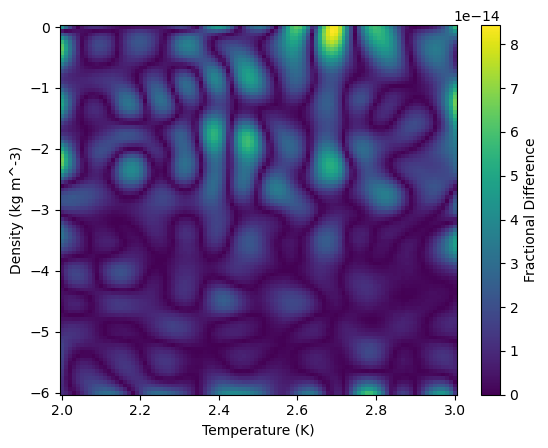

In [20]:
# (b) check that interpolation is thermodynamically correct
# Numerically compute derivatives

#P_interp(T, Rho) -> x = T and y = Rho
Log_dPdT_p = P_interpLog.partial_derivative(dx=1, dy=0)(np.log10(TTemp), np.log10(RRho), grid=False)
Log_dSdn_T = S_interpLog.partial_derivative(dx=0, dy=1)(np.log10(TTemp), np.log10(RRho), grid=False)


LHS = -(m/(np.log(10)*RRho))*Log_dSdn_T
RHS = (m/RRho)**2 * (RRho/m) * Log_dPdT_p
# Pressure = P_interpLog(np.log10(TTemp), np.log10(RRho), grid=False)


Log_frac_diff = (RHS - LHS)/RHS
#print(Log_frac_diff)


#plot
plt.pcolormesh(np.log10(TTemp), np.log10(RRho), abs(Log_frac_diff), cmap='viridis')
plt.colorbar(label='Fractional Difference')
plt.xlabel('Temperature (K)')
plt.ylabel('Density (kg m^-3)')
#plt.title('Fractional error - Entropy')
plt.show()

This is nicer! 

Does it make sense that we are getting round of error for the fractional difference in derivatives? 

Yes! Essentially, the interpolator is fitting the functions exactly. This makes sense since in $log T$ and $log \rho$ space, $S$ and $log P$ look linear. So, we are fitting a spline to a line, which gives us round-off errors only. 